<a href="https://colab.research.google.com/github/kecosz/rELA/blob/main/rELA0_51_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial for rELA 0.51
### Note:
### from v0.46
*Formatting* now works even if "basemetadata" is not given. Also, in *Formatting*, the parameter for specifying whether normalization is performed changed from "normalizeq" to "normalize".

## Setup

In [1]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## rpy2 version specification
### Required to successfully execute "%load_ext rpy2.ipython" as of 2023/1
!pip install rpy2==3.5.1
#!pip install --upgrade ipykernel
%load_ext rpy2.ipython

###The following codes is just for not showing rpy2 messages related to R package installation on google colab
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314929 sha256=59b1a9baca04960de5dcc4456c591bd7e555a3e03dbf049b9943077bb0d2f14e
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2
rm: cannot remove 'rELA': No such file or directory
Cloning into 'rELA'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 274 (delta 41), reused 60 (delta 26), pack-reused 175
Receiving objects: 100% (274/274), 5.85 MiB | 19.64 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [2]:
%%R
# [for Google Colab]
# from v0.50, Due to errors in installing igraph and tidygraph
system("add-apt-repository -y ppa:marutter/rrutter4.0")
system("add-apt-repository -y ppa:c2d4u.team/c2d4u4.0+")
system("add-apt-repository ppa:cran/v8")
system("apt-get update")
system("apt-get install libnode-dev")
system("apt-get install r-cran-igraph r-cran-tidygraph")

In [3]:
%%R
## package instllation
install.packages("Rcpp")
install.packages("RcppArmadillo")
install.packages("doParallel")
install.packages('tidyverse')
install.packages('gsubfn')
install.packages('zoo')
install.packages('plyr')
install.packages('gtools')
install.packages('ggsci')
#install.packages('igraph')
#install.packages('tidygraph')
install.packages('RColorBrewer')
install.packages("stringdist")
install.packages("purrr")
install.packages("plot3D")
library("Rcpp")
library("RcppArmadillo")
library("doParallel")
library('tidyverse')
library('gsubfn')
library('zoo')
library('plyr')
library('gtools')
library('ggsci')
library('igraph')
library('tidygraph')
library('RColorBrewer')
library("stringdist")
library("purrr")
library("plot3D")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()       masks base::%||%()
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
%%R
# install rELA package
install.packages("rELA/rELA.v0.51.tar.gz")
library("rELA")

## Energy Landscape Analysis

### Download data

In [5]:
%%R
# Specify the path for your own data in the code below, if necessary.
baseabtable <- read.csv('rELA/data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('rELA/data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [6]:
%%R
head(basemetadata, 7)

         factor.1   factor.2
sample.1    -0.92 2.79692115
sample.2     0.34 2.14701252
sample.3    -0.92 1.60611363
sample.4    -0.24 0.58476465
sample.5     0.40 1.73161379
sample.6    -0.82 2.95971753
sample.7     0.36 0.07787331


In [7]:
%%R
# To group species with the same presence/absence pattern into one group,
#set grouping to 1 and specify a number between 0 and 1 for grouping_th.
# If 0, only species with the same presence/absence pattern will be grouped together.
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata=NULL, normalize=1, parameters=c(0.01, 0.01, 0.99), grouping=1, grouping_th=0.)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


### Parameter fitting

In [8]:
%%R
#runSA: ocmatrix, env (environmental parameters; with>SA / without>fullSA), qth (threshold for stopping computation), rep (number of fitting processes to compute mean parameter value), threads (number of parallel threads)

sa <- runSA(ocmat=as.matrix(ocmat), qth=10^-5, rep=128, threads=2)


Start parameter fitting:
SA: elapsed time 56.49 sec



In [9]:
%%R
list[he,je,ge,hge] <- sa2params(sa)

In [10]:
%%R
he

 species.12  species.16   species.7   species.5   species.2  species.10 
-0.65304858 -0.48525627 -0.39069827 -0.54324397 -0.59288681 -0.85450608 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.09616610 -0.71874459 -0.35432985 -0.08446505  1.03312404  0.20668331 
  species.3  species.13   species.1   species.9 
 0.32209232  0.02286185  0.97202814  0.98400925 


In [11]:
%%R
hge

 species.12  species.16   species.7   species.5   species.2  species.10 
-0.65304858 -0.48525627 -0.39069827 -0.54324397 -0.59288681 -0.85450608 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.09616610 -0.71874459 -0.35432985 -0.08446505  1.03312404  0.20668331 
  species.3  species.13   species.1   species.9 
 0.32209232  0.02286185  0.97202814  0.98400925 


### Analysis and visualization of energy landscape
#### ELA function

In [ ]:
%%R
ela <- ELA(sa, env=NULL,
                SS.itr=20000, FindingTip.itr=10000, # <- the number of steps for finding stable states and tipping points (basically no need to change)
                threads=2, reporting=TRUE)

Start ELA:
4 stable states were found.
Checking 6 tipping points.
converting...
ELA: elapsed time 1.57 sec


In [ ]:
%%R
elap <- ELPruning(ela, th=0.05, threads=2)

Start pruning:
*...
ELPruning: elapsed time 5.21 sec


*ATTENTION*  
The return value of ELPruning is a list consisting of two elements, the first of which takes the same form as ELA, and the second of which indicates the correspondence between the stable states before and after pruning.

In [ ]:
%%R
list[stablestates, stablen, tippingpoints, tippingen] <- elap[[1]]

Stable states

In [ ]:
%%R
stablestates

[1] "09x" "EWB" "1uV"


Convert an integer representing a stable state (ssid) to a binary vector

In [ ]:
%%R
# ssid -> binary vector
bin = as.list(lapply(stablestates, function(x){id2bin(x, ncol(ocmat))}))
names(bin) <- stablestates
bin

$`09x`
 [1] 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1

$EWB
 [1] 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1

$`1uV`
 [1] 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1



Convert a binary vector to a ssid

In [ ]:
%%R
# binary vector -> ssid
as.vector(sapply(bin, bin2id))

[1] "09x" "EWB" "1uV"


Table of SSID, Energy, Community composition

In [ ]:
%%R
sstable(elap[[1]]) # or sstable(ela)

   ID            Energy species.12 species.16 species.7 species.5 species.2
1 09x -12.6576765719683          0          0         0         0         0
2 EWB -10.4712793295045          1          1         1         0         1
3 1uV -9.20720739806748          0          0         0         1         1
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         1          0          0         1         1          1
2          0         0          0          0         0         0          0
3          1         1          0          0         0         0          1
  species.3 species.13 species.1 species.9
1         1          0         1         1
2         1          0         1         1
3         1          1         1         1


Export the table to Google Drive in CSV format

In [ ]:
%%R
write.csv(x = sstable, file="drive/MyDrive/colab_export/sstable.csv") # "sstable.csv" is saved in "colab_export" folder of your Google Drive.

ID and energy of tipping points

In [ ]:
%%R
as.data.frame(tippingpoints)

   X1  X2  X3
1 Inf 4eB 1OV
2 Inf Inf 4eB
3 Inf Inf Inf


In [ ]:
%%R
as.data.frame(tippingen)

   X1        X2        X3
1 Inf -7.203617 -8.711717
2 Inf       Inf -7.203617
3 Inf       Inf       Inf


Table of TPID, SSID1, SSID2, Energy, Community composition

In [ ]:
%%R
tptable(elap[[1]])

   TP SS1 SS2            Energy species.12 species.16 species.7 species.5
1 4eB EWB 09x -7.20361707256732          0          1         0         0
2 1OV 1uV 09x -8.71171699304106          0          0         0         1
3 4eB 1uV EWB -7.20361707256732          0          1         0         0
  species.2 species.10 species.8 species.11 species.15 species.6 species.4
1         1          0         1          0          0         0         0
2         0          1         1          0          0         0         0
3         1          0         1          0          0         0         0
  species.14 species.3 species.13 species.1 species.9
1          0         1          0         1         1
2          1         1          1         1         1
3          0         1          0         1         1


Energy of any community composition


In [ ]:
%%R
cEnergy(ocmat[1,], he, je)

[1] -4.254202


Find the stable state for a community composition

In [ ]:
%%R
Bi(ocmat[1,], he, je)

[[1]]
[1] "01t"

[[2]]
[1] -11.66721



### Principal component analysis  
Observed community compositions plotted on a PC1,2 plane and color-coded by their stable states

NULL


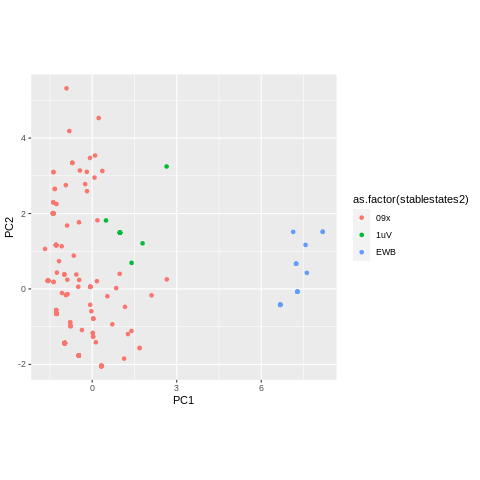

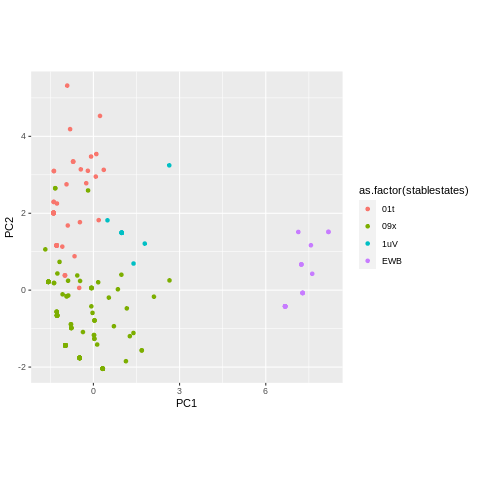

In [ ]:
%%R
PCplot(ocmat, sa, ssrep=elap[[2]])
PCplot(ocmat, sa, ssrep=elap[[2]], pruned=FALSE)

Disconnectivity graph


In [ ]:
%%R
showDG(elap[[1]], ocmat, "test")

### Visualization of species' interaction

NULL


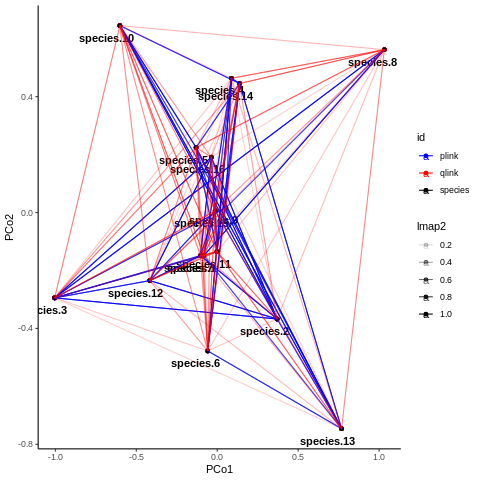

In [ ]:
%%R
showIntrGraph(elap[[1]], sa, th=0.01, # <- Threshold for links to be displayed
              annot_adj=c(0.75, 2.00))

### Energy landscape analysis with environmental gradients

In [ ]:
%%R
baseabtable <- read.csv('rELA/data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('rELA/data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [ ]:
%%R
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata, 1, c(0.01, 0.01, 0.99), 1, 0)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


In [ ]:
# Parameter fitting including environmental parameters
%%R
sa <- runSA(ocmat=as.matrix(ocmat), enmat=as.matrix(enmat), qth=10^-5, rep=256, threads=2)

Start parameter fitting
SA: elapsed time 142.18 sec



In [ ]:
%%R
gela <- GradELA(sa=sa, eid="factor.1", # Specify the label or position of an environmental factor
  enmat=enmat, env=NULL, range=NULL, steps=32, th=0.05, threads=8) #[[1]]: return value of ELA function for each step, [[2]]: value of environmental factor for each step, [[3]]: specified environmental factor

env not specified, the mean of enmat is used
processing(32) |================================|
Elapsed time 36.32 sec


NULL


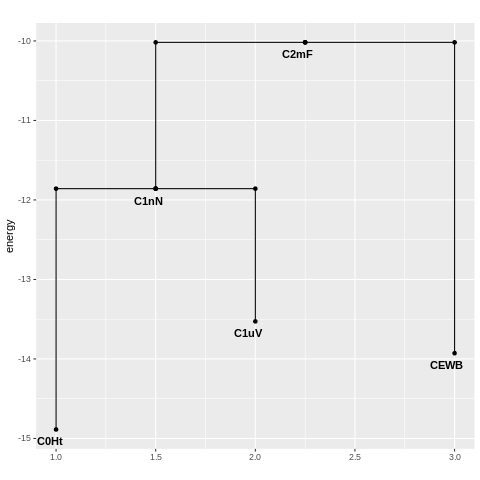

In [ ]:
# Disconnectivity graph
%%R
showDG(gela[[1]][[1]][[1]], ocmat)

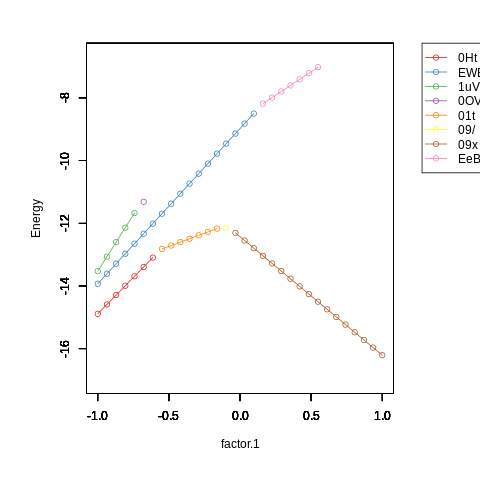

In [ ]:
# Stable state diagram
%%R
showSSD(gela)

In [ ]:
%%R
gstates <- foreach(x=gela[[1]], .combine='c') %do% {
    x[[1]][[1]]}
unique(gstates)

[1] "0Ht" "EWB" "1uV" "0OV" "01t" "09/" "09x" "EeB"


#### GradELA 3D plot (test)

In [ ]:
%%R
gelsobj <- GELSObj(gela, sa, threads=2)

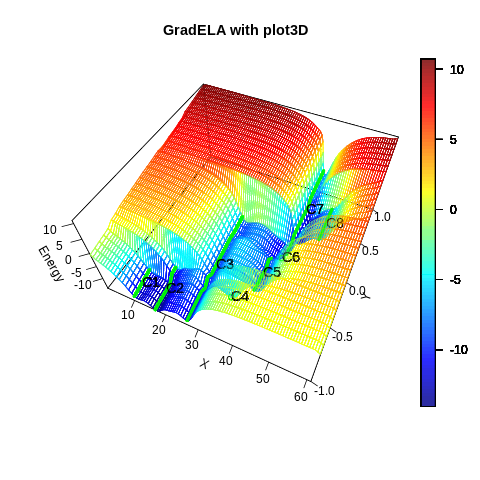

In [ ]:
%%R
showGELA3D(gelsobj)

## Stability

In [ ]:
%%R
stb <- Stability(sa, ocmat, enmat=NULL, threads=2)
head(stb, 5)

Start Stability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
Stability: elapsed time 5.40 sec

           energy.gap ss.entropy  e.realize  e.stable state.id stable.state.id
sample.1    9.8580274  0.0000000  -3.157208 -13.01523      07/             09x
sample.10   1.1289394  0.1943919 -11.886296 -13.01523      08/             09x
sample.100  6.2720757  0.0000000  -6.743159 -13.01523      1uF             09x
sample.101  0.4254829  0.2948328 -12.589752 -13.01523      09t             09x
sample.102  0.7567578  0.0000000 -12.258477 -13.01523      01t             09x


In [ ]:
%%R
stbwe <- Stability(sa, ocmat, enmat=enmat, threads=2)
head(stbwe, 5)

Start Stability:
Stability: elapsed time 31.76 sec

           energy.gap ss.entropy  e.realize  e.stable state.id stable.state.id
sample.1    7.5263789  1.1544604  -6.483739 -14.01012      07/             0Ht
sample.10   1.8769189  0.0000000 -11.909620 -13.78654      08/             09x
sample.100  1.3650384  1.5458076 -12.591872 -13.95691      1uF             1uV
sample.101  0.4434602  0.2948328 -11.532270 -11.97573      09t             01t
sample.102  0.0000000  1.1574917 -12.919802 -12.91980      01t             01t


gStability returns a list of 4 elements: the first two are the dataframe for pruned/non-pruned energy landscape, respectively. In addition to the dataframe of Stability it includes e.tipping (energy of tipping point) and energy.barrier (height of energy from observed state to the tipping point).The third output is a list of parameters (h, g, j, h+g*env) and a summary table of stable states, and the fourth output is a list encapsulating the inputs required for the various plots.  
  
output of gStability:  
[[1]]: data.frame(energy.gap, ss.entropy, energy.barrier, e.realize, e.stable, e.tipping, state.id, stable.state.id)  
[[2]]: data.frame(energy.gap.np, ss.entropy.np, energy.barrier.np, e.realize, e.stable.np, e.tipping.np, state.id.np, stable.state.id.np)  
[[3]]: w/ enmat: list(list(list(he, je, ge, hge), data.frame(sstable)), ...); w/o enmat: list(list(he, je, ge, hge), data.frame(sstable))  
[[4]]: w/ enmat: list(list(ocmat, env, sa, ela, elanp), ...); w/o enmat: list(ocmat, env, sa, ela, elanp)

In [ ]:
%%R
gstb <- gStability(sa, ocmat, enmat=NULL, threads=8)

Start gStability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
gStability: elapsed time 34.72 sec



In [ ]:
%%R
gstb[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize  e.stable e.tipping
sample.1    9.8580274 0.00000000       5.072019  -3.157208 -13.01523 -7.943216
sample.10   1.1289394 0.09377791       5.072019 -11.886296 -13.01523 -7.943216
sample.100  6.2720757 0.01140776       5.072019  -6.743159 -13.01523 -7.943216
sample.101  0.4254829 0.26915587       5.072019 -12.589752 -13.01523 -7.943216
sample.102  0.7567578 0.00000000       5.072019 -12.258477 -13.01523 -7.943216
sample.103  2.2316413 0.00000000       5.072019 -10.783594 -13.01523 -7.943216
sample.104  0.2487089 0.00000000       5.072019 -12.766526 -13.01523 -7.943216
sample.105  4.2989904 0.00000000       1.719213  -5.363439  -9.66243 -7.943216
           state.id stable.state.id
sample.1        07/             09x
sample.10       08/             09x
sample.100      1uF             09x
sample.101      09t             09x
sample.102      01t             09x
sample.103      0Ht             09x
sample.104      09/             09x
s

In [ ]:
%%R
gstb[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1       9.8580274    0.00000000          5.072019  -3.157208   -13.01523
sample.10      1.1289394    0.00000000          5.072019 -11.886296   -13.01523
sample.100     6.2720757    0.24685851          5.072019  -6.743159   -13.01523
sample.101     0.4254829    0.00000000          5.072019 -12.589752   -13.01523
sample.102     0.7567578    0.39864579          5.072019 -12.258477   -13.01523
sample.103     2.2316413    0.06017244          5.072019 -10.783594   -13.01523
sample.104     0.2487089    0.95143683          5.072019 -12.766526   -13.01523
sample.105     4.2989904    0.31541909          1.719213  -5.363439    -9.66243
           e.tipping.np state.id.np stable.state.id.np
sample.1      -7.943216         07/                09x
sample.10     -7.943216         08/                09x
sample.100    -7.943216         1uF                09x
sample.101    -7.943216         09t                09x
sampl

In [ ]:
%%R
gstbe <- gStability(sa, ocmat, enmat=enmat, th=0.2, threads=8)

Start gStability:
gStability: elapsed time 157.64 sec



In [ ]:
%%R
length(gstbe[[4]])

[1] 256


In [ ]:
%%R
gstbe[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize   e.stable
sample.1    7.5263789  0.8725651       4.839091  -6.483739 -14.010118
sample.10   1.8769189  0.0000000            Inf -11.909620 -13.786539
sample.100  1.3650384  1.4836946       1.920920 -12.591872 -13.956910
sample.101  0.4434602  0.0000000       6.423782 -11.532270 -11.975730
sample.102  0.0000000  0.4999160       6.487534 -12.919802 -12.919802
sample.103  0.0000000  0.9775387       5.862038 -13.701383 -13.701383
sample.104  0.6169727  0.0000000            Inf -12.038118 -12.655090
sample.105  2.3415772  0.3154191       1.565533  -6.463395  -8.804972
            e.tipping state.id stable.state.id
sample.1    -9.171027      07/             0Ht
sample.10         Inf      08/             09x
sample.100 -12.035990      1uF             1uV
sample.101  -5.551948      09t             01t
sample.102  -6.432268      01t             01t
sample.103  -7.839345      0Ht             0Ht
sample.104        Inf      09/           

In [ ]:
%%R
gstbe[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1       7.5263789     1.3414422          3.264951  -6.483739  -14.010118
sample.10      1.8769189     0.0000000          6.489965 -11.909620  -13.786539
sample.100     1.3650384     1.5535033          1.920920 -12.591872  -13.956910
sample.101     0.4434602     0.1791163          6.423782 -11.532270  -11.975730
sample.102     0.0000000     1.1989931          2.478379 -12.919802  -12.919802
sample.103     0.0000000     0.7526071          2.533014 -13.701383  -13.701383
sample.104     0.6169727     0.0000000          5.585553 -12.038118  -12.655090
sample.105     2.3415772     0.0000000          1.565533  -6.463395   -8.804972
           e.tipping.np state.id.np stable.state.id.np
sample.1     -10.745167         07/                0Ht
sample.10     -7.296575         08/                09x
sample.100   -12.035990         1uF                1uV
sample.101    -5.551948         09t                01t
sampl

===================================================================================

In [ ]:
## list(he,je,ge,hge)
%%R
sample.id <- 1
gstbe[[3]][[sample.id]][[1]]
# if enmat=NULL, remove "[[sample.id]]"

[[1]]
 species.12  species.16   species.7   species.5   species.2  species.10 
-1.90238454 -1.58935749 -1.58652389 -1.61547994 -1.47540824 -1.80618837 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.42957669 -2.78740821 -2.03814847 -0.05685571  1.58150712  0.92829926 
  species.3  species.13   species.1   species.9 
 0.86160921 -0.37260565  2.35199056  2.58277461 

[[2]]
           species.12 species.16  species.7   species.5   species.2
species.12  0.0000000  1.6956737  1.6789384 -0.49532690  1.32603929
species.16  1.6956737  0.0000000  1.5341114 -0.54385665  1.11580072
species.7   1.6789384  1.5341114  0.0000000 -0.54954620  1.08634290
species.5  -0.4953269 -0.5438567 -0.5495462  0.00000000  1.02661929
species.2   1.3260393  1.1158007  1.0863429  1.02661929  0.00000000
species.10 -0.7259438 -0.8247739 -0.6327587  0.51735947  0.31263823
species.8  -1.3598572 -1.0248558 -0.9925105  0.12724699 -0.48629969
species.11 -0.1392368 -0.1531364 -0.1561962  0.476255

In [ ]:
## stablestates
%%R
sample.id <- 100
gstbe[[3]][[sample.id]][[2]]
# if enmat=NULL, remove "[[sample.id]]

   ID            Energy species.12 species.16 species.7 species.5 species.2
1 09x -15.9969136441802          0          0         0         0         0
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         1          0          0         1         1          1
  species.3 species.13 species.1 species.9
1         1          0         1         1


In [ ]:
%%R
length(gstbe[[4]][[1]][[4]][[1]][[1]])

[1] 3


In [ ]:
%%R
sapply(seq(256), function(x) {length(gstbe[[4]][[x]][[4]][[1]][[1]]) - length(gstbe[[4]][[x]][[5]][[1]])})

  [1] -1 -1  0  0 -1 -2 -1  0 -1  0 -1  0  0  0 -1 -1  0 -1 -2 -1 -1 -1 -1 -1 -1
 [26]  0  0  0  0 -2  0 -1 -2  0 -1  0  0 -2  0 -1  0  0  0 -2  0  0  0 -1  0 -2
 [51] -1 -1  0  0  0  0 -1 -1 -1 -2 -2 -1 -1 -1  0  0  0  0 -1 -1  0  0 -1 -1  0
 [76]  0 -1 -1 -1  0  0 -1  0 -1  0  0  0 -1  0 -1 -1 -1  0  0 -1 -2 -1  0  0 -1
[101] -2 -1 -1  0  0 -1 -2 -1 -2  0 -1 -1 -1 -2 -2 -2 -1  0 -1  0  0  0 -1  0  0
[126] -1 -1 -1 -2 -1 -1 -1  0 -1  0  0 -2  0 -1  0  0  0 -1  0  0 -2 -2  0 -1 -2
[151] -1  0 -1 -1  0 -1  0 -2 -2  0  0 -2 -1  0 -2  0 -1 -1 -1  0  0  0 -1 -2 -1
[176] -2 -1 -1  0  0  0 -1  0 -1  0  0 -1  0 -1  0  0  0 -1 -1 -1 -1 -1 -1 -1  0
[201] -1 -1  0 -1  0  0 -1 -1  0  0 -1 -1 -1  0  0 -1  0 -2  0 -1 -1  0  0 -1 -1
[226]  0 -1  0 -1 -2 -1 -2 -2 -1  0 -1 -1  0 -1  0 -1  0 -1 -1  0 -1  0 -1  0 -1
[251] -1 -1 -2  0 -1 -1


In [ ]:
%%R
ela <- gstbe[[4]][[sample.id]][[4]]
ela

[[1]]
[[1]][[1]]
[1] "09x"

[[1]][[2]]
[1] -15.99691

[[1]][[3]]
[[1]][[3]]$`1`
[1] "Inf"


[[1]][[4]]
[[1]][[4]]$`1`
[1] Inf



[[2]]
  ss.before.pruning ss.after.pruning
1               09x              09x
2               EeB              09x



In [ ]:
%%R
elanp <- gstbe[[4]][[sample.id]][[5]]
elanp

[[1]]
[1] "09x" "EWB"

[[2]]
[1] -12.667217  -7.929737

[[3]]
[[3]]$`1`
[1] "Inf" "Inf"

[[3]]$`2`
[1] "2eB" "Inf"


[[4]]
[[4]]$`1`
[1] Inf Inf

[[4]]$`2`
[1] -7.12163      Inf




NULL


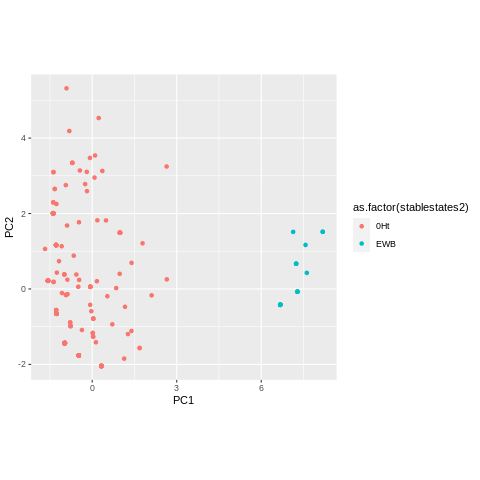

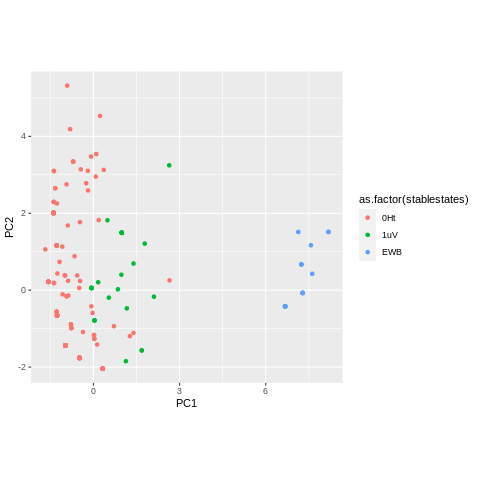

In [ ]:
## PCplot
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
env <- gstbe[[4]][[sample.id]][[2]]
sa <- gstbe[[4]][[sample.id]][[3]]
ela <- gstbe[[4]][[sample.id]][[4]]
# if enmat=NULL, remove "[[sample.id]]"

PCplot(ocmat, sa, env, ssrep=ela[[2]])
PCplot(ocmat, sa, env, ssrep=ela[[2]], pruned=FALSE)

NULL


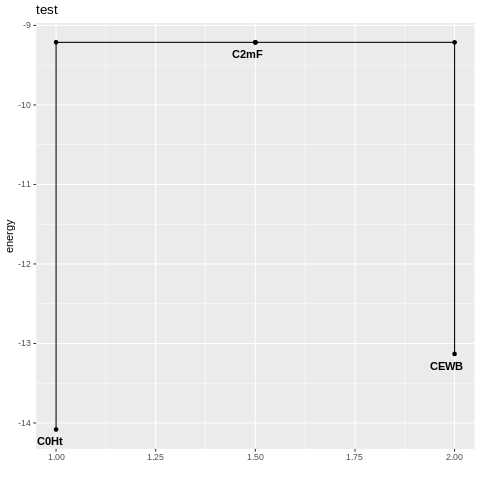

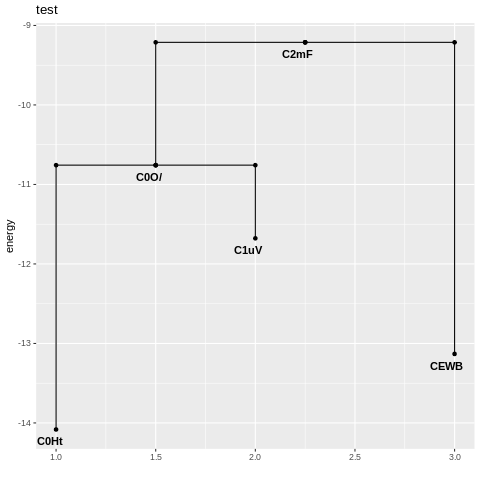

In [ ]:
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
ela <- gstbe[[4]][[sample.id]][[4]]
elanp <- gstbe[[4]][[sample.id]][[5]]
# if enmat=NULL, remove "[[sample.id]]"

showDG(ela[[1]], ocmat, "test")
showDG(elanp, ocmat, "test")

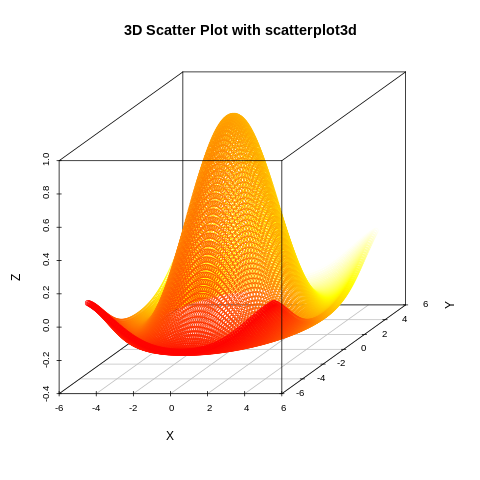

In [ ]:
%%R

# サンプルデータの生成
x <- seq(-5, 5, length.out = 100)
y <- seq(-5, 5, length.out = 100)
grid <- expand.grid(x = x, y = y)
grid$z <- with(grid, sin(sqrt(x^2 + y^2)) / sqrt(x^2 + y^2))

# 3D散布図のプロット
scatterplot3d(grid$x, grid$y, grid$z, color = heat.colors(10000),
              main = "3D Scatter Plot with scatterplot3d",
              xlab = "X", ylab = "Y", zlab = "Z")